In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
def rle_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    print(rle.shape)
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

In [4]:
df = pd.read_csv('../../submission.csv')
df.head(2)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1


(520,)
(442,)
(450,)
(372,)
(482,)
(752,)


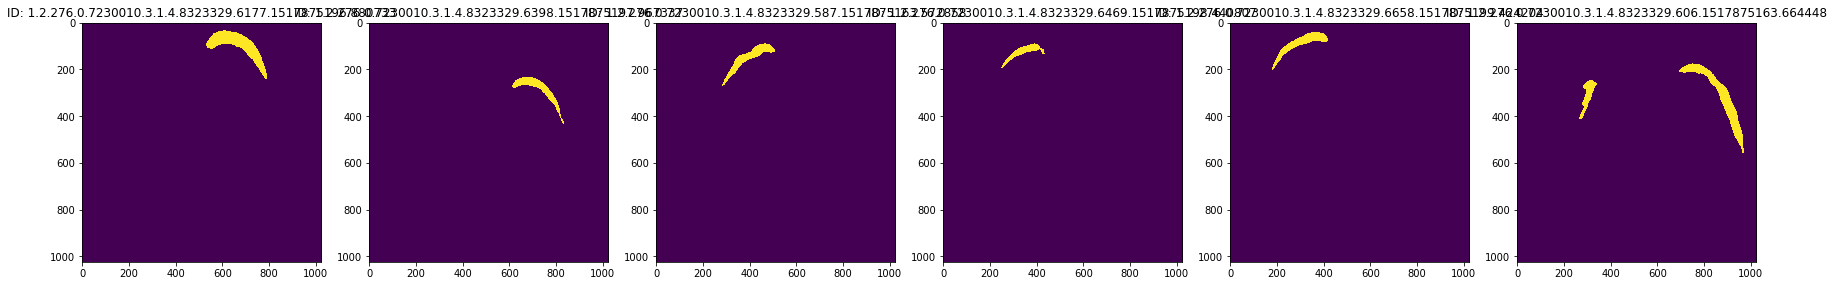

In [6]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('../../submission.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'EncodedPixels'])!='-1':        
        decoded_mask = rle_decode(df.loc[i,'EncodedPixels'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'ImageId'])
        j = j + 1
        if j>5:
            break
    i = i + 1

(520,)
(442,)
(450,)
(372,)
(482,)
(752,)


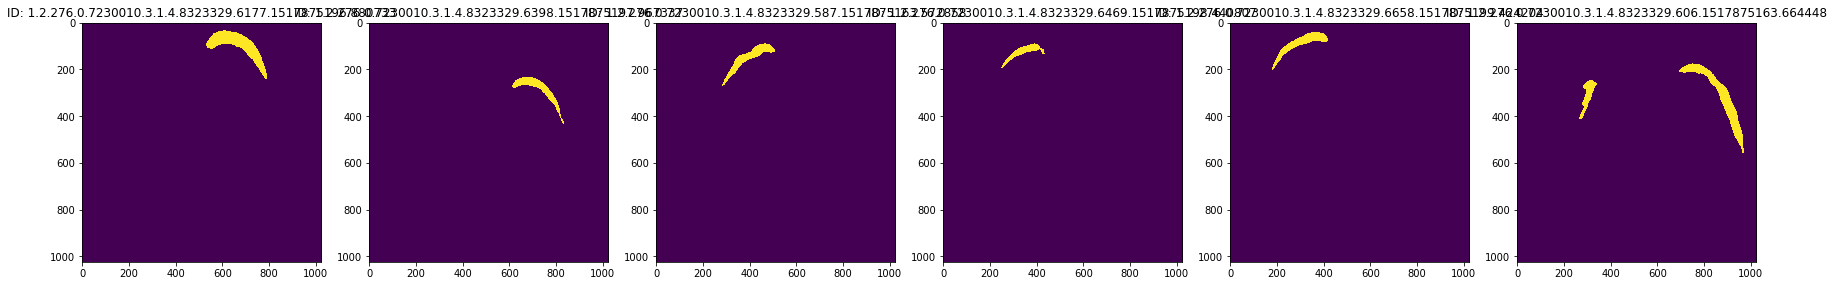

In [9]:
# from utils import run_length_decoding, run_length_encoding

df = pd.read_csv('../../submission.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'EncodedPixels'])!="-1":        
        decoded_mask = rle_decode(df.loc[i,'EncodedPixels'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'ImageId'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [10]:
from utils import run_length_encode

In [11]:
import cv2

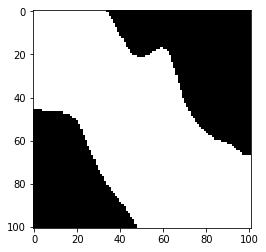

In [13]:
filename = r'G:\salt\train\masks\0a1742c740.png'
mask = cv2.imread(filename)

plt.imshow(mask)


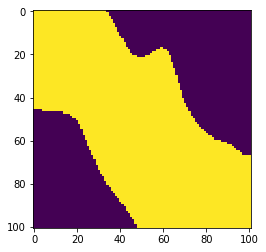

In [17]:
encoded_rle = rle_encode(mask)

decoded_mask = run_length_decoding(encoded_rle, (101,101))
plt.imshow(decoded_mask)


In [18]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)
    mask_img = np.uint32(mask_img)
#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [19]:
from config import TEST_IMG_DIR_RAW
test_path = TEST_IMG_DIR_RAW+"/"

(442,)
(336,)
(276,)


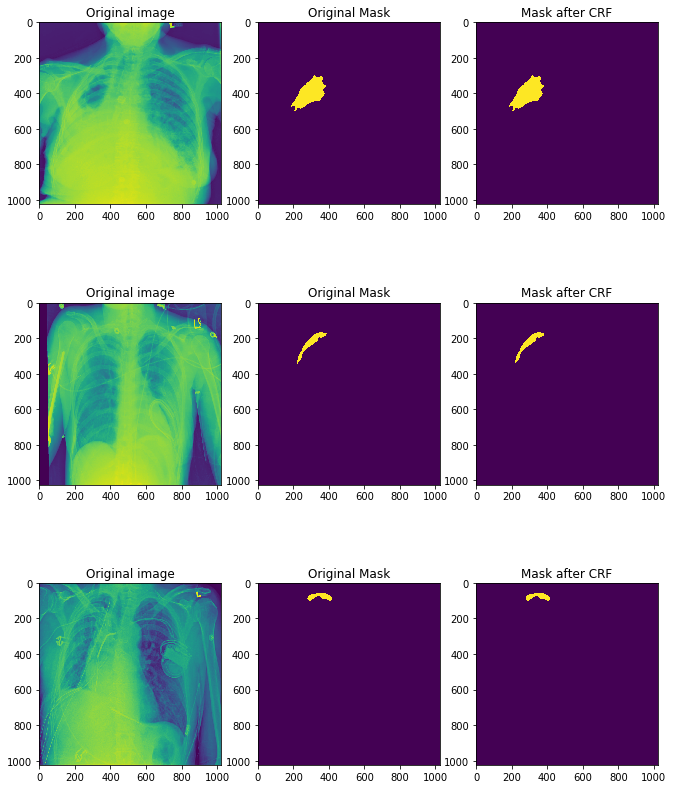

In [20]:
"""
visualizing the effect of applying CRF

"""
nImgs = 3
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'EncodedPixels'])!="-1":        
        decoded_mask = rle_decode(df.loc[i,'EncodedPixels'])        
        orig_img = imread(test_path+df.loc[i,'ImageId']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [12]:
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [24]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'EncodedPixels'])!="-1":        
        decoded_mask = rle_decode(df.loc[i,'EncodedPixels'])        
        orig_img = imread(test_path+df.loc[i,'ImageId']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'EncodedPixels'] = run_length_encode(crf_output)

  0%|          | 0/1372 [00:00<?, ?it/s]

(520,)


  0%|          | 3/1372 [00:00<07:00,  3.25it/s]

(442,)


  1%|          | 7/1372 [00:01<06:25,  3.54it/s]

(450,)


  1%|          | 14/1372 [00:02<05:22,  4.21it/s]

(372,)


  2%|▏         | 21/1372 [00:03<04:41,  4.80it/s]

(482,)


  2%|▏         | 27/1372 [00:04<04:20,  5.17it/s]

(752,)


  3%|▎         | 38/1372 [00:05<03:35,  6.19it/s]

(332,)


  3%|▎         | 41/1372 [00:06<04:38,  4.78it/s]

(584,)


  4%|▎         | 50/1372 [00:07<03:54,  5.64it/s]

(572,)


  4%|▍         | 52/1372 [00:08<05:42,  3.85it/s]

(536,)


  5%|▍         | 66/1372 [00:09<04:23,  4.96it/s]

(270,)


  5%|▌         | 69/1372 [00:10<04:59,  4.35it/s]

(358,)


  6%|▌         | 81/1372 [00:11<03:56,  5.45it/s]

(382,)


  6%|▌         | 82/1372 [00:12<08:34,  2.51it/s]

(966,)


  6%|▋         | 89/1372 [00:12<06:46,  3.15it/s]

(490,)


  7%|▋         | 92/1372 [00:13<06:38,  3.21it/s]

(462,)


  8%|▊         | 105/1372 [00:14<05:03,  4.18it/s]

(328,)


  9%|▉         | 121/1372 [00:15<03:50,  5.43it/s]

(478,)


  9%|▉         | 123/1372 [00:16<05:25,  3.84it/s]

(354,)


  9%|▉         | 125/1372 [00:17<06:40,  3.12it/s]

(284,)


  9%|▉         | 128/1372 [00:18<06:28,  3.20it/s]

(358,)


 10%|█         | 138/1372 [00:19<05:02,  4.08it/s]

(446,)


 10%|█         | 143/1372 [00:20<04:37,  4.42it/s]

(382,)


 11%|█         | 145/1372 [00:20<05:56,  3.44it/s]

(406,)


 11%|█         | 154/1372 [00:21<04:44,  4.29it/s]

(204,)


 11%|█▏        | 155/1372 [00:22<08:53,  2.28it/s]

(468,)


 12%|█▏        | 169/1372 [00:23<06:31,  3.07it/s]

(222,)


 12%|█▏        | 170/1372 [00:24<09:56,  2.01it/s]

(520,)


 13%|█▎        | 176/1372 [00:25<07:51,  2.54it/s]

(544,)


 13%|█▎        | 177/1372 [00:26<10:49,  1.84it/s]

(344,)


 14%|█▍        | 196/1372 [00:27<07:43,  2.53it/s]

(460,)


 15%|█▍        | 202/1372 [00:28<06:16,  3.11it/s]

(546,)


 15%|█▍        | 205/1372 [00:29<06:04,  3.20it/s]

(230,)


 15%|█▌        | 207/1372 [00:29<06:50,  2.84it/s]

(336,)


 15%|█▌        | 209/1372 [00:30<07:27,  2.60it/s]

(474,)


 15%|█▌        | 211/1372 [00:31<07:47,  2.48it/s]

(404,)


 16%|█▌        | 215/1372 [00:32<06:42,  2.87it/s]

(502,)


 16%|█▌        | 220/1372 [00:33<05:43,  3.35it/s]

(674,)


 17%|█▋        | 229/1372 [00:34<04:31,  4.21it/s]

(722,)


 17%|█▋        | 235/1372 [00:35<03:59,  4.75it/s]

(876,)


 18%|█▊        | 242/1372 [00:36<03:30,  5.36it/s]

(386,)


 18%|█▊        | 245/1372 [00:37<04:08,  4.53it/s]

(332,)


 18%|█▊        | 247/1372 [00:37<05:21,  3.49it/s]

(424,)


 20%|█▉        | 268/1372 [00:38<03:55,  4.69it/s]

(564,)


 20%|█▉        | 274/1372 [00:39<03:33,  5.15it/s]

(596,)


 21%|██        | 283/1372 [00:40<03:00,  6.04it/s]

(1032,)


 21%|██▏       | 293/1372 [00:41<02:34,  6.98it/s]

(258,)


 22%|██▏       | 296/1372 [00:42<03:22,  5.32it/s]

(582,)


 22%|██▏       | 300/1372 [00:43<03:33,  5.03it/s]

(764,)


 23%|██▎       | 311/1372 [00:44<02:54,  6.10it/s]

(594,)


 23%|██▎       | 322/1372 [00:45<02:25,  7.21it/s]

(450,)


 24%|██▎       | 323/1372 [00:46<06:20,  2.76it/s]

(502,)


 24%|██▍       | 327/1372 [00:46<05:36,  3.10it/s]

(342,)


 24%|██▍       | 330/1372 [00:47<05:26,  3.19it/s]

(946,)


 24%|██▍       | 331/1372 [00:48<08:24,  2.06it/s]

(524,)


 24%|██▍       | 332/1372 [00:49<10:36,  1.63it/s]

(284,)


 24%|██▍       | 333/1372 [00:50<12:00,  1.44it/s]

(336,)


 24%|██▍       | 335/1372 [00:51<10:43,  1.61it/s]

(676,)


 26%|██▌       | 354/1372 [00:52<07:36,  2.23it/s]

(288,)


 27%|██▋       | 364/1372 [00:53<05:43,  2.94it/s]

(618,)


 27%|██▋       | 367/1372 [00:54<05:29,  3.05it/s]

(482,)


 27%|██▋       | 369/1372 [00:54<06:05,  2.75it/s]

(414,)


 28%|██▊       | 384/1372 [00:55<04:28,  3.67it/s]

(754,)


 29%|██▉       | 396/1372 [00:56<03:27,  4.70it/s]

(336,)


 29%|██▉       | 403/1372 [00:57<03:01,  5.33it/s]

(292,)


 30%|██▉       | 407/1372 [00:58<03:10,  5.07it/s]

(300,)


 30%|███       | 412/1372 [00:59<03:03,  5.22it/s]

(478,)


 30%|███       | 415/1372 [01:00<03:33,  4.48it/s]

(172,)


 31%|███▏      | 429/1372 [01:01<02:45,  5.71it/s]

(502,)


 32%|███▏      | 445/1372 [01:02<02:09,  7.17it/s]

(524,)


 33%|███▎      | 448/1372 [01:03<02:54,  5.31it/s]

(414,)


 33%|███▎      | 451/1372 [01:03<03:22,  4.55it/s]

(310,)


 34%|███▎      | 460/1372 [01:04<02:47,  5.46it/s]

(548,)


 34%|███▍      | 468/1372 [01:05<02:26,  6.18it/s]

(132,)


 35%|███▍      | 475/1372 [01:06<02:15,  6.63it/s]

(160,)


 35%|███▌      | 482/1372 [01:07<02:07,  6.97it/s]

(392,)


 36%|███▌      | 492/1372 [01:08<01:51,  7.86it/s]

(514,)


 36%|███▌      | 493/1372 [01:09<05:09,  2.84it/s]

(534,)


 37%|███▋      | 501/1372 [01:10<04:03,  3.58it/s]

(314,)


 37%|███▋      | 510/1372 [01:10<03:14,  4.43it/s]

(448,)


 37%|███▋      | 512/1372 [01:11<04:10,  3.44it/s]

(732,)


 38%|███▊      | 527/1372 [01:12<03:07,  4.52it/s]

(402,)


 40%|████      | 549/1372 [01:13<02:17,  5.99it/s]

(448,)


 40%|████      | 551/1372 [01:14<03:24,  4.01it/s]

(314,)


 42%|████▏     | 571/1372 [01:15<02:30,  5.33it/s]

(336,)


 42%|████▏     | 580/1372 [01:16<02:07,  6.20it/s]

(456,)


 43%|████▎     | 587/1372 [01:17<01:58,  6.64it/s]

(318,)


 44%|████▎     | 599/1372 [01:18<01:38,  7.84it/s]

(472,)


 44%|████▍     | 607/1372 [01:18<01:34,  8.14it/s]

(460,)


 44%|████▍     | 610/1372 [01:19<02:14,  5.68it/s]

(490,)


 45%|████▌     | 620/1372 [01:20<01:52,  6.67it/s]

(350,)


 45%|████▌     | 623/1372 [01:21<02:26,  5.13it/s]

(144,)


 46%|████▌     | 625/1372 [01:22<03:20,  3.73it/s]

(458,)


 46%|████▌     | 627/1372 [01:23<03:59,  3.11it/s]

(598,)


 46%|████▌     | 628/1372 [01:24<06:06,  2.03it/s]

(406,)


 47%|████▋     | 638/1372 [01:25<04:32,  2.69it/s]

(498,)


 47%|████▋     | 645/1372 [01:26<03:36,  3.36it/s]

(548,)


 47%|████▋     | 648/1372 [01:26<03:35,  3.35it/s]

(490,)


 48%|████▊     | 656/1372 [01:27<02:52,  4.14it/s]

(256,)


 48%|████▊     | 661/1372 [01:28<02:38,  4.49it/s]

(436,)


 49%|████▉     | 669/1372 [01:29<02:13,  5.27it/s]

(476,)


 49%|████▉     | 671/1372 [01:30<03:05,  3.78it/s]

(316,)


 49%|████▉     | 678/1372 [01:31<02:35,  4.48it/s]

(992,)


 49%|████▉     | 679/1372 [01:32<04:53,  2.36it/s]

(414,)


 51%|█████     | 698/1372 [01:33<03:29,  3.22it/s]

(442,)


 52%|█████▏    | 709/1372 [01:34<02:39,  4.15it/s]

(336,)


 53%|█████▎    | 723/1372 [01:34<02:02,  5.31it/s]

(276,)


 53%|█████▎    | 730/1372 [01:35<01:48,  5.91it/s]

(410,)


 54%|█████▎    | 735/1372 [01:36<01:49,  5.83it/s]

(822,)


 54%|█████▍    | 741/1372 [01:37<01:43,  6.07it/s]

(504,)


 54%|█████▍    | 742/1372 [01:38<04:04,  2.58it/s]

(356,)


 54%|█████▍    | 743/1372 [01:39<05:39,  1.85it/s]

(298,)


 54%|█████▍    | 744/1372 [01:40<06:46,  1.54it/s]

(508,)


 55%|█████▍    | 748/1372 [01:41<05:25,  1.92it/s]

(546,)


 56%|█████▌    | 768/1372 [01:42<03:48,  2.64it/s]

(476,)


 56%|█████▌    | 771/1372 [01:43<03:33,  2.82it/s]

(116,)


 57%|█████▋    | 783/1372 [01:43<02:39,  3.70it/s]

(328,)


 57%|█████▋    | 785/1372 [01:44<03:09,  3.10it/s]

(360,)


 59%|█████▉    | 809/1372 [01:45<02:13,  4.22it/s]

(374,)


 60%|█████▉    | 821/1372 [01:46<01:43,  5.33it/s]

(340,)


 60%|██████    | 827/1372 [01:47<01:37,  5.58it/s]

(1286,)


 60%|██████    | 829/1372 [01:48<02:25,  3.74it/s]

(142,)


 61%|██████    | 836/1372 [01:49<02:01,  4.41it/s]

(454,)


 61%|██████    | 838/1372 [01:50<02:40,  3.32it/s]

(420,)


 61%|██████    | 840/1372 [01:51<03:09,  2.80it/s]

(418,)


 61%|██████▏   | 841/1372 [01:52<04:44,  1.86it/s]

(320,)


 61%|██████▏   | 842/1372 [01:53<05:46,  1.53it/s]

(710,)


 63%|██████▎   | 859/1372 [01:54<04:03,  2.11it/s]

(380,)


 63%|██████▎   | 865/1372 [01:55<03:12,  2.63it/s]

(1032,)


 63%|██████▎   | 869/1372 [01:56<02:50,  2.95it/s]

(642,)


 63%|██████▎   | 871/1372 [01:56<03:07,  2.67it/s]

(474,)


 64%|██████▍   | 879/1372 [01:59<03:01,  2.72it/s]

(224,)


 64%|██████▍   | 881/1372 [02:03<06:38,  1.23it/s]

(442,)


 64%|██████▍   | 884/1372 [02:04<05:21,  1.52it/s]

(426,)


 65%|██████▍   | 887/1372 [02:05<04:26,  1.82it/s]

(450,)


 65%|██████▌   | 896/1372 [02:06<03:17,  2.41it/s]

(570,)


 66%|██████▌   | 899/1372 [02:07<03:01,  2.61it/s]

(252,)


 66%|██████▌   | 902/1372 [02:08<02:51,  2.74it/s]

(462,)


 66%|██████▌   | 903/1372 [02:08<04:07,  1.89it/s]

(338,)


 66%|██████▋   | 911/1372 [02:09<03:06,  2.48it/s]

(316,)


 66%|██████▋   | 912/1372 [02:10<04:12,  1.82it/s]

(306,)


 67%|██████▋   | 913/1372 [02:11<04:59,  1.53it/s]

(316,)


 68%|██████▊   | 929/1372 [02:12<03:30,  2.11it/s]

(464,)


 68%|██████▊   | 932/1372 [02:13<03:04,  2.38it/s]

(530,)


 68%|██████▊   | 934/1372 [02:14<03:07,  2.34it/s]

(600,)


 69%|██████▊   | 940/1372 [02:15<02:29,  2.89it/s]

(434,)


 69%|██████▉   | 944/1372 [02:16<02:12,  3.24it/s]

(294,)


 69%|██████▉   | 950/1372 [02:17<01:49,  3.85it/s]

(426,)


 69%|██████▉   | 951/1372 [02:17<03:09,  2.22it/s]

(168,)


 70%|██████▉   | 955/1372 [02:18<02:38,  2.63it/s]

(328,)


 70%|██████▉   | 956/1372 [02:19<03:41,  1.88it/s]

(644,)


 70%|██████▉   | 960/1372 [02:20<03:01,  2.27it/s]

(622,)


 70%|███████   | 961/1372 [02:21<03:55,  1.74it/s]

(514,)


 70%|███████   | 967/1372 [02:22<03:00,  2.24it/s]

(714,)


 71%|███████   | 974/1372 [02:23<02:19,  2.85it/s]

(112,)


 72%|███████▏  | 983/1372 [02:24<01:46,  3.64it/s]

(362,)


 72%|███████▏  | 994/1372 [02:25<01:21,  4.62it/s]

(364,)


 73%|███████▎  | 1003/1372 [02:25<01:06,  5.52it/s]

(416,)


 74%|███████▍  | 1014/1372 [02:26<00:54,  6.60it/s]

(438,)


 74%|███████▍  | 1016/1372 [02:27<01:25,  4.18it/s]

(394,)


 74%|███████▍  | 1019/1372 [02:28<01:30,  3.89it/s]

(332,)


 74%|███████▍  | 1021/1372 [02:29<01:49,  3.20it/s]

(956,)


 74%|███████▍  | 1022/1372 [02:30<02:50,  2.05it/s]

(584,)


 75%|███████▍  | 1025/1372 [02:31<02:30,  2.31it/s]

(610,)


 75%|███████▍  | 1026/1372 [02:32<03:16,  1.76it/s]

(396,)


 75%|███████▍  | 1027/1372 [02:33<03:50,  1.50it/s]

(352,)


 76%|███████▌  | 1038/1372 [02:33<02:44,  2.03it/s]

(288,)


 77%|███████▋  | 1052/1372 [02:34<01:56,  2.75it/s]

(294,)


 78%|███████▊  | 1066/1372 [02:35<01:23,  3.66it/s]

(272,)
(674,)


 78%|███████▊  | 1068/1372 [02:37<02:19,  2.18it/s]

(468,)


 78%|███████▊  | 1077/1372 [02:38<01:43,  2.85it/s]

(386,)


 79%|███████▉  | 1089/1372 [02:39<01:15,  3.73it/s]

(608,)


 80%|███████▉  | 1091/1372 [02:40<01:29,  3.13it/s]

(484,)


 80%|███████▉  | 1092/1372 [02:41<02:17,  2.04it/s]

(270,)


 80%|████████  | 1103/1372 [02:41<01:38,  2.73it/s]

(300,)


 82%|████████▏ | 1125/1372 [02:42<01:06,  3.72it/s]

(344,)


 82%|████████▏ | 1127/1372 [02:43<01:18,  3.12it/s]

(458,)


 82%|████████▏ | 1131/1372 [02:44<01:10,  3.43it/s]

(558,)


 83%|████████▎ | 1136/1372 [02:45<01:00,  3.90it/s]

(562,)


 83%|████████▎ | 1140/1372 [02:46<00:57,  4.06it/s]

(580,)


 84%|████████▎ | 1149/1372 [02:47<00:45,  4.95it/s]

(468,)


 84%|████████▍ | 1154/1372 [02:48<00:42,  5.11it/s]

(392,)


 84%|████████▍ | 1158/1372 [02:49<00:43,  4.93it/s]

(420,)


 85%|████████▍ | 1164/1372 [02:49<00:38,  5.35it/s]

(372,)


 86%|████████▌ | 1180/1372 [02:50<00:28,  6.78it/s]

(562,)


 86%|████████▋ | 1185/1372 [02:51<00:29,  6.37it/s]

(380,)


 87%|████████▋ | 1187/1372 [02:52<00:45,  4.08it/s]

(308,)


 87%|████████▋ | 1188/1372 [02:53<01:20,  2.29it/s]

(234,)


 87%|████████▋ | 1191/1372 [02:54<01:11,  2.53it/s]

(480,)


 87%|████████▋ | 1195/1372 [02:55<01:00,  2.90it/s]

(524,)


 87%|████████▋ | 1197/1372 [02:56<01:05,  2.67it/s]

(320,)


 87%|████████▋ | 1198/1372 [02:57<01:32,  1.89it/s]

(474,)


 87%|████████▋ | 1199/1372 [02:57<01:50,  1.56it/s]

(424,)


 88%|████████▊ | 1210/1372 [02:58<01:16,  2.11it/s]

(328,)


 88%|████████▊ | 1214/1372 [02:59<01:02,  2.52it/s]

(446,)


 89%|████████▉ | 1223/1372 [03:00<00:45,  3.25it/s]

(328,)


 89%|████████▉ | 1224/1372 [03:01<01:11,  2.08it/s]

(238,)


 89%|████████▉ | 1227/1372 [03:02<01:01,  2.35it/s]

(500,)


 90%|████████▉ | 1233/1372 [03:03<00:47,  2.92it/s]

(1020,)


 90%|█████████ | 1236/1372 [03:04<00:44,  3.04it/s]

(310,)


 90%|█████████ | 1238/1372 [03:05<00:48,  2.75it/s]

(306,)


 90%|█████████ | 1240/1372 [03:06<00:51,  2.57it/s]

(342,)


 92%|█████████▏| 1257/1372 [03:06<00:33,  3.47it/s]

(662,)


 93%|█████████▎| 1279/1372 [03:07<00:19,  4.68it/s]

(238,)


 94%|█████████▎| 1285/1372 [03:08<00:16,  5.15it/s]

(954,)


 94%|█████████▍| 1294/1372 [03:09<00:12,  6.04it/s]

(606,)


 95%|█████████▍| 1300/1372 [03:10<00:11,  6.26it/s]

(258,)


 95%|█████████▍| 1302/1372 [03:11<00:17,  4.06it/s]

(322,)


 95%|█████████▌| 1305/1372 [03:12<00:17,  3.84it/s]

(570,)


 97%|█████████▋| 1324/1372 [03:13<00:09,  5.09it/s]

(906,)


 97%|█████████▋| 1330/1372 [03:14<00:07,  5.46it/s]

(420,)


 98%|█████████▊| 1349/1372 [03:14<00:03,  7.04it/s]

(472,)


 99%|█████████▊| 1353/1372 [03:15<00:03,  6.04it/s]

(504,)


 99%|█████████▉| 1365/1372 [03:16<00:00,  7.27it/s]

(604,)


100%|█████████▉| 1368/1372 [03:17<00:00,  5.47it/s]

(290,)


100%|██████████| 1372/1372 [03:18<00:00,  6.92it/s]


In [25]:
df.to_csv('crf_correction.csv',index=False)